# Assignment 1: Sampling and Reproducibility

The code at the end of this file explores contact tracing data about an outbreak of the flu, and demonstrates the dangers of incomplete and non-random samples. This assignment is modified from [Contact tracing can give a biased sample of COVID-19 cases](https://andrewwhitby.com/2020/11/24/contact-tracing-biased/) by Andrew Whitby.

Examine the code below. Identify all stages at which sampling is occurring in the model. Describe in words the sampling procedure, referencing the functions used, sample size, sampling frame, any underlying distributions involved. 


> `infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)`
> - **Sampling procedure:** Simple random sampling - randomly select a subset of individuals from the population to infect without replacement.
>
> - **Sampling frame:** All individuals in the population `(ppl.index)`. 
> - **Sample size:** 10% of the total population (100 out of 1,000 individuals).
> - **Underlying distribution:** Discrete uniform distribution - each individual has an equal chance of being infected.

> `ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS`
> - `ppl['infected']` is a boolean series.
> - `sum(ppl['infected'])` gives the count of infected people.
> - `np.random.rand(sum(ppl['infected']))` generates a random number between 0 and 1 for each infected person, drawn from a uniform distribution U(0,1). Then we compare them to TRACE_SUCCESS to determine if tracing is successful. We obtain a boolean series. *True* means that the tracing was successful for that infected person and *False* means it was not.
> - `.loc[]` is used to set the 'traced' column for those who are infected. Rounding up for each infected person, we generate a random number between 0 and 1 and if it is less than TRACE_SUCCESS, we mark them as traced.
>
> - **Sampling procedure:** Random sampling with success probability TRACE_SUCCESS.
> - **Sampling frame:** All 100 infected individuals.
> - **Sample size:** ~20% of infected individuals (approximately 20 out of 100, varies per run).
> - **Underlying distribution:** Bernoulli distribution - each infected person (out of 100) is independently chosen to be traced with a 20% chance (TRACE_SUCCESS).

Modify the number of repetitions in the simulation to 10 and 100 (from the original 1000). Run the script multiple times and observe the outputted graphs. Comment on the reproducibility of the results.

> Reducing the number of repetitions (from 1000 to 10 or 100) leads to less stable histograms with higher variability. This shows that the simulation results are less reproducible when the number of iterations is low due to random noise.
> - When the simulations have 10 repetitions: the graphs differ a lot between runs and within a given simulation, there tends to be a large difference between infections and traces.  
> - When simulations have 100 repetitions: the graphs across different simulations don't vary so much and within a given simulation, there tends to be more alignment between infections and traces. 
> - When simulations have 1000 repetitions: the results become more stable and within a given simulation, traces are more closely approximate with infections and the graphs become smoother and more bell-shaped.
>
> With many repetitions, we gain stability: the proportions converge (Law of Large Numbers), traces better approximate infections and the distributions begin to resemble a normal curve (as one would expect because of the Central Limit Theorem for proportions).
>
> Each time we run a simulation we get a different result because it is fed different random numbers. To avoid this lack of reproducibility, we need to fix a random seed which guarantees that the same sequence of random numbers is used in each run.

Alter the code so that it is reproducible. Describe the changes you made to the code and how they affected the reproducibility of the script. The output needs to produce the same output when run multiple times.

> To make the results reproducible, I added `np.random.seed(42)` before defining the *simulate_event* function. This fixed the randomness, so running the simulation multiple times with the same settings gives the same results every time.

## Code

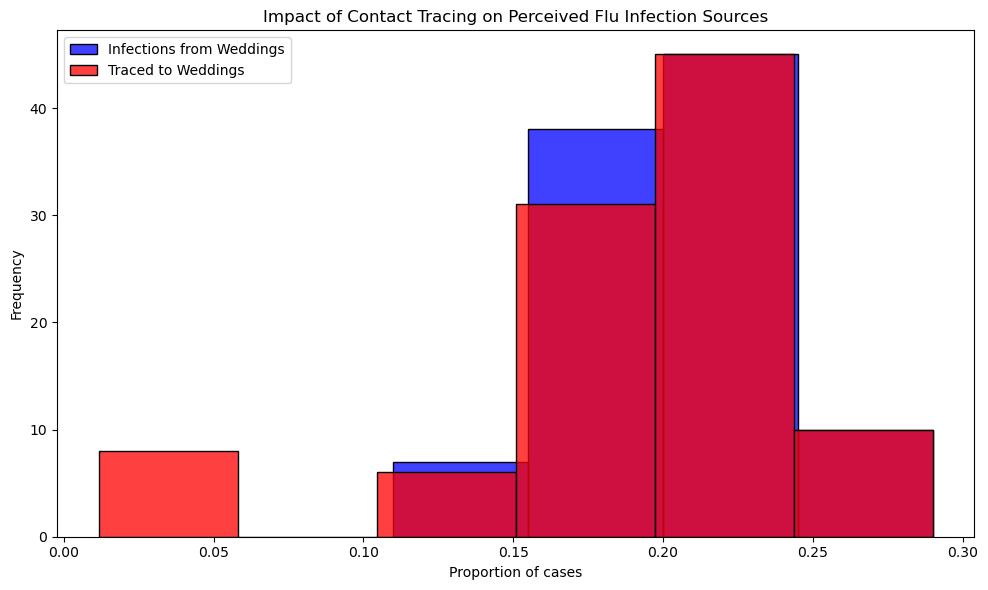

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Note: Suppressing FutureWarnings to maintain a clean output. This is specifically to ignore warnings about
# deprecated features in the libraries we're using (e.g., 'use_inf_as_na' option in Pandas, used by Seaborn),
# which we currently have no direct control over. This action is taken to ensure that our output remains
# focused on relevant information, acknowledging that we rely on external library updates to fully resolve
# these deprecations. Always consider reviewing and removing this suppression after significant library updates.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Constants representing the parameters of the model
ATTACK_RATE = 0.10
TRACE_SUCCESS = 0.20
SECONDARY_TRACE_THRESHOLD = 2

# We need to set a random seed for reproducibility
np.random.seed(42)

def simulate_event(m):
  """
  Simulates the infection and tracing process for a series of events.
  
  This function creates a DataFrame representing individuals attending weddings and brunches,
  infects a subset of them based on the ATTACK_RATE, performs primary and secondary contact tracing,
  and calculates the proportions of infections and traced cases that are attributed to weddings.
  
  Parameters:
  - m: Dummy parameter for iteration purposes.
  
  Returns:
  - A tuple containing the proportion of infections and the proportion of traced cases
    that are attributed to weddings.
  """
  # Create DataFrame for people at events with initial infection and traced status
  events = ['wedding'] * 200 + ['brunch'] * 800   # First 200 people at weddings, last 800 people at brunches
  ppl = pd.DataFrame({
      'event': events,
      'infected': False,  # Initialize all as not infected
      'traced': np.nan  # Initially setting traced status as NaN
  })

  # Explicitly set 'traced' column to nullable boolean type
  ppl['traced'] = ppl['traced'].astype(pd.BooleanDtype())   # np.nan will be treated as missing and becomes <NA>

  # Infect a random subset of people
  infected_indices = np.random.choice(ppl.index, size=int(len(ppl) * ATTACK_RATE), replace=False)   # Randomly select a subset of individual indices from the population to infect without replacement
  ppl.loc[infected_indices, 'infected'] = True    # Mark these people as infected

  # Primary contact tracing: randomly decide which infected people get traced
  ppl.loc[ppl['infected'], 'traced'] = np.random.rand(sum(ppl['infected'])) < TRACE_SUCCESS
  # ppl['infected'] is a boolean series
  # sum(ppl['infected']) gives the count of infected people
  # np.random.rand(sum(ppl['infected'])) generates random numbers between 0 and 1
    # One random number for each infected person and compares them to TRACE_SUCCESS to determine if tracing is successful, it is a boolean series
    # Each True means that the tracing was successful for that infected person and each False means it was not
  # .loc[] is used to set the 'traced' column for those who are infected
  # This means that for each infected person, we generate a random number and if it is less than TRACE_SUCCESS, we mark them as traced

  # Secondary contact tracing based on event attendance
  event_trace_counts = ppl[ppl['traced'] == True]['event'].value_counts()   
  # Filters the DataFrame to only include traced people, gets the event value for those traced people, then counts how many times each event type has been traced
  events_traced = event_trace_counts[event_trace_counts >= SECONDARY_TRACE_THRESHOLD].index
  # This gets the events that have been traced at least SECONDARY_TRACE_THRESHOLD times
  ppl.loc[ppl['event'].isin(events_traced) & ppl['infected'], 'traced'] = True
  # For infected people who attended events that have been traced at least SECONDARY_TRACE_THRESHOLD times, we mark them as traced
    # This means that if an event has been traced at least SECONDARY_TRACE_THRESHOLD times, all infected people who attended that event are marked as traced
  # This is a secondary tracing step, where we trace all infected people who attended events that have been traced at least SECONDARY_TRACE_THRESHOLD times

  # Calculate proportions of infections and traces attributed to each event type
  ppl['event_type'] = ppl['event'].str[0]  # 'w' for wedding, 'b' for brunch 
  # This creates a new column 'event_type' that contains the first letter of the event type, 'w' for wedding and 'b' for brunch
  wedding_infections = sum(ppl['infected'] & (ppl['event_type'] == 'w'))
  # Count infections at weddings
  brunch_infections = sum(ppl['infected'] & (ppl['event_type'] == 'b'))
  # Count infections at brunches
  
  p_wedding_infections = wedding_infections / (wedding_infections + brunch_infections) # Calculate the proportion of infections attributed to weddings

  wedding_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'w'))  # Count infected traced cases at weddings
  brunch_traces = sum(ppl['infected'] & ppl['traced'] & (ppl['event_type'] == 'b')) # Count infected traced cases at brunches
  p_wedding_traces = wedding_traces / (wedding_traces + brunch_traces)  # Calculate the proportion of traced cases attributed to weddings

  return p_wedding_infections, p_wedding_traces   # This returns a tuple with the proportions of infections and traces attributed to weddings
  # This is done to contrast real infections and traced cases (perception) of infections

# Run the simulation 1000 times
results = [simulate_event(m) for m in range(100)] # This is the line we change to modify the number of repetitions in the simulation - instead of 1000, we can use 10 or 100
props_df = pd.DataFrame(results, columns=["Infections", "Traces"]) # Convert results to DataFrame for easier analysis
# This creates a DataFrame with 2 columns, 'Infections' and 'Traces' where:
  # Each row corresponds to a simulation run
  # Each column contains the proportion of infections (% of actual infections from weddings) and traces (% of traced cases from weddings) attributed to weddings

# Plotting the results
plt.figure(figsize=(10, 6))
sns.histplot(props_df['Infections'], color="blue", alpha=0.75, binwidth=0.05, kde=False, label='Infections from Weddings')
sns.histplot(props_df['Traces'], color="red", alpha=0.75, binwidth=0.05, kde=False, label='Traced to Weddings')
plt.xlabel("Proportion of cases")
plt.ylabel("Frequency")
plt.title("Impact of Contact Tracing on Perceived Flu Infection Sources")
plt.legend()
plt.tight_layout()
plt.show()

## Criteria

|Criteria|Complete|Incomplete|
|--------|----|----|
|Alteration of the code|The code changes made, made it reproducible.|The code is still not reproducible.|
|Description of changes|The author answered questions and explained the reasonings for the changes made well.|The author did not answer questions or explain the reasonings for the changes made well.|

## Submission Information
🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `23:59 - 12/10/2025`
* The branch name for your repo should be: `assignment-1`
* What to submit for this assignment:
    * This markdown file (`a1_sampling_and_reproducibility.ipynb`) should be populated with the code changed.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/sampling/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

#### Checklist:
- [ ] Create a branch called `assignment-1`.
- [ ] Ensure that the repository is public.
- [ ] Review [the PR description guidelines](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md#guidelines-for-pull-request-descriptions) and adhere to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via the help channel in Slack. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.
